#### Using files and bag of words features from https://www.kaggle.com/c/word2vec-nlp-tutorial and useful ML algorithm suggestions and nice seaborn plots from http://bugra.github.io/work/notes/2014-11-22/an-introduction-to-supervised-learning-scikit-learn/

In [1]:
%matplotlib inline

In [2]:
import nltk
from nltk import *
import pandas as pd

In [3]:
from bs4 import BeautifulSoup
import seaborn
import matplotlib
import matplotlib.pyplot as plt
import numpy
import unittest

#### Use pandas to read information from the training data file 

In [4]:
train = pd.read_csv("labeledTrainData.tsv", header=0, \
                    delimiter="\t", quoting=3)

#### Function to make the text easy to work with 

In [5]:
#My modified function for taking text with some html tags and turning it into nice ML features
def filter_records(record):
  first = BeautifulSoup(record,"lxml").get_text()
#Modify the nltk stopwords list to exclude some words I think are useful
  my_stopwords = set([u'i', u'me', u'my', u'myself', u'we', u'our', u'ours', u'ourselves', u'you', u'your', 
                      u'yours', u'yourself', u'yourselves', u'he', u'him', u'his', u'himself', u'she', u'her',
                      u'hers', u'herself', u'it', u'its', u'itself', u'they', u'them', u'their', u'theirs',
                      u'themselves', u'what', u'which', u'who', u'whom', u'this', u'that', u'these', u'those',
                      u'am', u'is', u'are', u'was', u'were', u'be', u'been', u'being', u'have', u'has', u'had',
                      u'having', u'do', u'does', u'did', u'doing', u'a', u'an', u'the', u'and', u'if', u'or',
                      u'as', u'while', u'of', u'at', u'by', u'for', u'with', u'about', u'between', u'into',
                      u'through', u'during', u'before', u'after', u'above', u'below', u'to', u'from', u'up', 
                      u'down', u'in', u'out', u'on', u'off', u'over', u'under', u'again', u'further', u'then',
                      u'once', u'here', u'there', u'when', u'where', u'why', u'how', u'own', u's', u't', u'can',
                      u'will', u'just', u'don', u'should', u'now', u'd', u'll', u'm', u'o', u're', u've', u'y'])
#Remove symbols and numbers, make everything lower case
  import re
  re_fit = re.sub("[^a-zA-Z]", " ", first).lower()
#Tokenize
  tok_first = nltk.word_tokenize(re_fit)
#Remove stop words
  slt_first = set([w for w in tok_first if not w in my_stopwords])
#Stem and Lemm
  lem = nltk.WordNetLemmatizer()
  sltl_first = set([lem.lemmatize(t) for t in slt_first])
  mstem = nltk.LancasterStemmer()
  sltls_first = set([mstem.stem(t) for t in sltl_first])
  return sltls_first," ".join(sltls_first)

#### Loop over all reviews and add the formatted text to a single list

In [6]:
sltsl_first=[]
kag_list = []
num_reviews = train["review"].size
for i in xrange(0,num_reviews):
  sltsl,kag = filter_records(train["review"][i])
  sltsl_first += sltsl
  kag_list.append(kag)


#### Initial suggestion from Kaggle competition, bag of words features

In [7]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(analyzer = "word",   \
                             tokenizer = None,    \
                             preprocessor = None, \
                             stop_words = None,   \
                             max_features = 5000) 
train_data_features = vectorizer.fit_transform(kag_list)
train_data_features = train_data_features.toarray()

#### Get my 2grams and 3grams. Frequency is currently very much guesswork. Want to come up with a method of determining how good set of bigrams or trigrams is based on the most common bigrams and trigrams, possibly from Google ngrams

In [8]:
#Function to get bigrams and trigrams for concatenated list of all reviews (filt_test), extracting n features (n_feat), 
# with colocations within a window of size win_size, requiring that the gram be as frequent as samp_frac*len(filt_test)
def get_grams(filt_test,n_feat=500,win_size=3,samp_frac=0.00005):
  bigram_measures = nltk.collocations.BigramAssocMeasures()
  trigram_measures = nltk.collocations.TrigramAssocMeasures()
#Find most significant bigrams and trigram colocations in filt_test within window win_size 
  if(win_size==2):
    bi_finder = BigramCollocationFinder.from_words(filt_test)
    tri_finder = TrigramCollocationFinder.from_words(filt_test)
  elif(win_size>2):
    bi_finder = BigramCollocationFinder.from_words(filt_test,window_size=win_size)
    tri_finder = TrigramCollocationFinder.from_words(filt_test,window_size=win_size)
  else: 
    raise ValueError('Window size must be greater than or equal to two') 
#Require at least int(samp_frac*len(filt_test)) frequency in full text
  bi_finder.apply_freq_filter(int(samp_frac*len(filt_test)))
  tri_finder.apply_freq_filter(int(samp_frac*len(filt_test)))
# Determine significance of colocation with pointwise mutual information
  bigrams = set(bi_finder.nbest(bigram_measures.pmi, n_feat))
  trigrams = set(tri_finder.nbest(trigram_measures.pmi, n_feat))
#Make sure I have as many features as I expect
  assert (len(bigrams)==n_feat and len(trigrams)==n_feat),'This is not the right number of features!!!!!'
#Otherwise return my grams
  return bigrams,trigrams

#Get my grams
my_bigrams,my_trigrams = get_grams(sltsl_first,500,5)

#### Create my own simple vectorizer to make features from each individual review from my 2grams and 3grams

In [9]:
#Function to create features for list of space separated review texts (full_list), from the bigrams (bigs) and 
#trigrams (trigs)
def my_features(full_list,bigs,trigs):
#Create numpy arrays for the features with len(full_list) arrays of length len(grams)
  bi_vecs = numpy.zeros((len(full_list),len(bigs)))
  tri_vecs = numpy.zeros((len(full_list),len(trigs))) 
#Get all the reviews from the full list
  for ind,rev in enumerate(full_list):
    bcount = 0
    tcount = 0
    text = rev.split(' ')
#Create all the bigrams and trigrams for this text
    a_bigrams = nltk.bigrams(text)
    a_trigrams = nltk.trigrams(text)
#Get a dictionary of the bigrams mapped to their frequency 
    bf_dist = nltk.FreqDist(a_bigrams)
    tf_dist = nltk.FreqDist(a_trigrams)
#Get the frequency of occurence of a bigram from the full list I created from the list of bigrams in this text
    for k,v in bf_dist.items():
        if(k in bigs):
            bcount+=1
            b_ind = list(bigs).index(k)
            #print 'Big',k,v,b_ind,list(bigs)[b_ind]
            bi_vecs[ind][b_ind]=v
#Get the frequency of occurence of a trigram from the full list I created from the list of trigrams in this text
    for k,v in tf_dist.items():
        if(k in trigs):
            tcount+=1
            t_ind = list(trigs).index(k)
            #print 'Trig',k,v,t_ind,list(trigs)[t_ind]
            tri_vecs[ind][t_ind]=v  
#Check every time that the number of times that one of the entries in bigs or trigs is in 
  # bfdist or tfdist is the number of non-zero entries of the nth array in bi_vecs or tri_vecs
    assert(sum(bi_vecs[ind])==bcount and sum(tri_vecs[ind])==tcount),'Number of features not equal to grams in input lists'
#If test passed return features
  return bi_vecs,tri_vecs

#### Create 2gram and 3gram features

In [10]:
bi_features,tri_features = my_features(kag_list,my_bigrams,my_trigrams)

#### Do cross validation and train multiple ML algorithms with scikit-learn

In [11]:
import sklearn

from sklearn import cross_validation
from sklearn import tree
from sklearn import svm
from sklearn import ensemble
from sklearn import neighbors
from sklearn import linear_model
from sklearn import metrics
from sklearn import preprocessing

#### Method to do kfold cross validation (stratification not necessary because sample is 50/50 positive and negative reviews)

In [12]:
#Get test sets from k folds and train on remainder k times to determine the prediction accuracy of different 
# ML techniques
def kfold_cv(X, y, clf_class, n_folds=10, **kwargs):
#Define cross validation folds
    k_fold = cross_validation.KFold(len(y), n_folds=n_folds)
    y_pred = y.copy()
#Train algorithm on k folds
    for ii, jj in k_fold:
        X_train, X_test = X[ii], X[jj]
        y_train = y[ii]
        clf = clf_class(**kwargs)
        clf.fit(X_train,y_train)
        y_pred[jj] = clf.predict(X_test)
    return y_pred

#### Test Kaggle bag of words features

In [13]:
#Function to test the accuracy of quick ML algorithms. Output is % of correct identifications
def print_fastscores(features,sentiment):
#Save classifiers for future use
  pa_classifier = kfold_cv(features, sentiment, linear_model.PassiveAggressiveClassifier)
  rf_classifier = kfold_cv(features, sentiment, ensemble.RandomForestClassifier)
  lr_classifier = kfold_cv(features, sentiment, linear_model.LogisticRegression)
#Print accuracy score, or % correct identifications
  print('Passive Aggressive Classifier: {:.2f}'.format(metrics.accuracy_score(sentiment, pa_classifier)))
  print('Random Forest Classifier:      {:.2f}'.format(metrics.accuracy_score(sentiment, rf_classifier)))

  print('Logistic Regression:           {:.2f}'.format(metrics.accuracy_score(sentiment, lr_classifier)))
  print('Dump Classifier: {:.2f}'.format(metrics.accuracy_score(sentiment, [0 for ii in sentiment.tolist()])))
#Output my saved classifiers
  return pa_classifier,rf_classifier,lr_classifier
pa_class,rf_class,lr_class = print_fastscores(train_data_features,train["sentiment"])

Passive Aggressive Classifier: 0.84
Random Forest Classifier:      0.76
Logistic Regression:           0.86
Dump Classifier: 0.50


#### Methods that are incredibly slow using the bag of words with 5000 features

In [14]:
#Function to test the accuracy of slow ML algorithms. Output is % of correct identifications
def print_slowscores(features,sentiment):
#Print accuracy score, or % correct identifications
  print('K Nearest Neighbor Classifier: {:.2f}'.format(metrics.accuracy_score(sentiment, kfold_cv(features, 
                                                    sentiment, neighbors.KNeighborsClassifier))))
  print('Gradient Boosting Classifier:  {:.2f}'.format(metrics.accuracy_score(sentiment, kfold_cv(features, 
                                                    sentiment, ensemble.GradientBoostingClassifier))))
  print('Support vector machine(SVM):   {:.2f}'.format(metrics.accuracy_score(sentiment, kfold_cv(features, 
                                                    sentiment, svm.SVC))))

/usr/local/lib/python2.7/dist-packages/IPython/core/formatters.py:92: DeprecationWarning: DisplayFormatter._ipython_display_formatter_default is deprecated: use @default decorator instead.
  def _ipython_display_formatter_default(self):
/usr/local/lib/python2.7/dist-packages/IPython/core/formatters.py:669: DeprecationWarning: PlainTextFormatter._singleton_printers_default is deprecated: use @default decorator instead.
  def _singleton_printers_default(self):


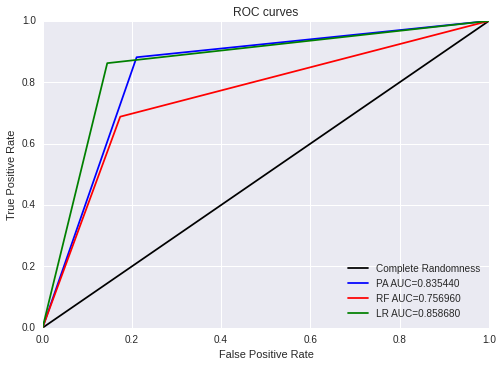

In [15]:
from sklearn.metrics import roc_curve, auc
#Function to produce ROC curves
def fast_roc_curves(sentiment,pa_classifier,rf_classifier,lr_classifier):
  plt.title('ROC curves')
  fp_rate,tp_rate,threshold = roc_curve(sentiment, pa_classifier)
  auc_val = auc(fp_rate,tp_rate)
  seaborn.set_style("darkgrid")
  plt.plot([0,1],[0,1],'k',label='Complete Randomness')
  plt.plot(fp_rate,tp_rate,'b',label='PA AUC=%f' % auc_val)
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.legend(loc=4)
  plt.plot()
    

  fp_rate,tp_rate,threshold = roc_curve(sentiment, rf_classifier)
  auc_val = auc(fp_rate,tp_rate)
  seaborn.set_style("darkgrid")
  plt.plot(fp_rate,tp_rate,'r',label='RF AUC=%f' % auc_val)
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.legend(loc=4)
  plt.plot()

 
  fp_rate,tp_rate,threshold = roc_curve(sentiment, lr_classifier)
  auc_val = auc(fp_rate,tp_rate)
  seaborn.set_style("darkgrid")
  plt.plot(fp_rate,tp_rate,'g',label='LR AUC=%f' % auc_val)
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.legend(loc=4)
  plt.plot()
fast_roc_curves(train["sentiment"], pa_class,rf_class,lr_class)

#### Look at confusion matrices to see explicitly what the failing and passing rates are for each classification

In [16]:
#Function to produce confusion matrices (compare correct label of each entry on y axis to predicted label on x axis)
def fast_confusion_matrices(sentiment,pa_classifier,rf_classifier,lr_classifier):
#Create confusion matrices
  pass_agg_conf_matrix = metrics.confusion_matrix(sentiment, pa_classifier)
  random_forest_conf_matrix = metrics.confusion_matrix(sentiment, rf_classifier)
  logistic_reg_conf_matrix = metrics.confusion_matrix(sentiment, lr_classifier)
  dumb_conf_matrix = metrics.confusion_matrix(sentiment, [0 for ii in sentiment.tolist()])
#Return confusion matrices
  return pass_agg_conf_matrix,random_forest_conf_matrix,logistic_reg_conf_matrix,dumb_conf_matrix

pa_conf_matrix,rf_conf_matrix,lr_conf_matrix,dumb_conf_matrix = fast_confusion_matrices(train["sentiment"], 
                                                                         pa_class,rf_class,lr_class)

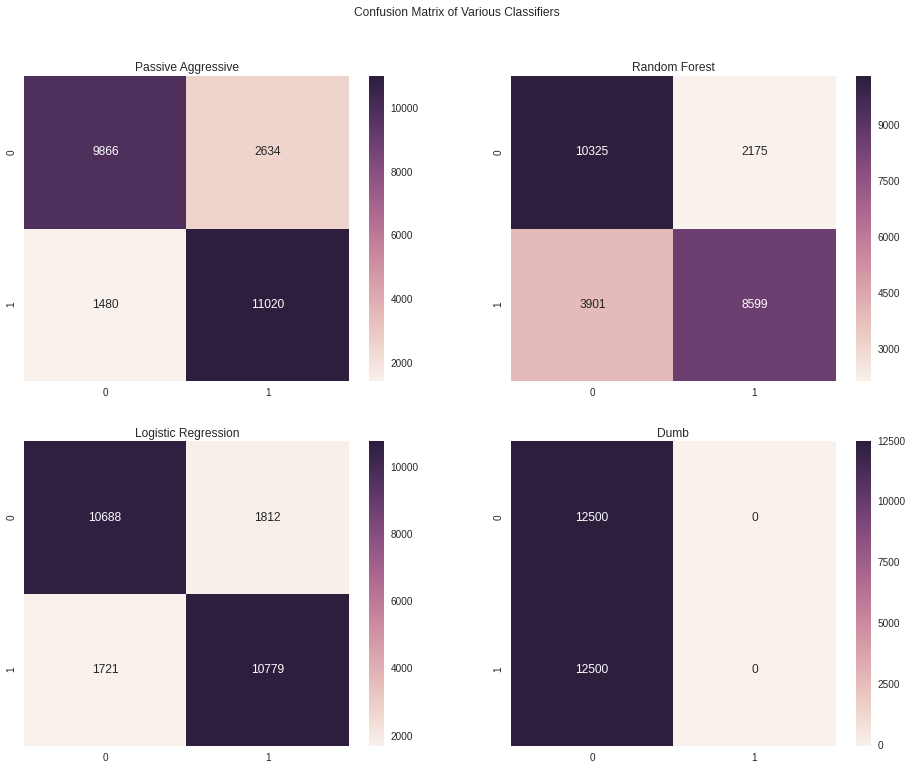

In [17]:
def draw_conf_matrix(pa_conf_mat,rf_conf_mat,lr_conf_mat,dumb_conf_mat):
#Use seaborn to make nice purple shaded plots of confusion matrices
  conf_matrix = {
                1: {
                    'matrix': pa_conf_mat,
                    'title': 'Passive Aggressive',
                   },
                2: {
                    'matrix': rf_conf_mat,
                    'title': 'Random Forest',
                   },
                3: {
                    'matrix': lr_conf_mat,
                    'title': 'Logistic Regression',
                   },
                4: {
                    'matrix': dumb_conf_mat,
                    'title': 'Dumb',
                   },
  }
  fix, ax = plt.subplots(figsize=(16, 12))
  plt.suptitle('Confusion Matrix of Various Classifiers')
  for ii, values in conf_matrix.items():
    matrix = values['matrix']
    title = values['title']
    plt.subplot(2, 2, ii) 
    plt.title(title);
    seaborn.heatmap(matrix, annot=True,  fmt='');
    
#Draw confusion matrices for kaggle features with my fast classifiers
draw_conf_matrix(pa_conf_matrix,rf_conf_matrix,lr_conf_matrix,dumb_conf_matrix)

#### Fun fact: The kaggle competition suggests using a random forest and my test seems to indicate that this performs relatively poorly, and is the worst of the three fast ML methods

#### Test my bigram features

In [18]:
bpa_class,brf_class,blr_class = print_fastscores(bi_features,train["sentiment"])

Passive Aggressive Classifier: 0.54
Random Forest Classifier:      0.58
Logistic Regression:           0.61
Dump Classifier: 0.50


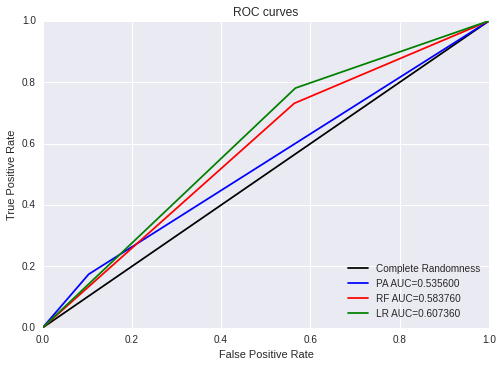

In [19]:
fast_roc_curves(train["sentiment"], bpa_class,brf_class,blr_class)

#### Test my trigram features

In [20]:
tpa_class,trf_class,tlr_class = print_fastscores(tri_features,train["sentiment"])

Passive Aggressive Classifier: 0.51
Random Forest Classifier:      0.52
Logistic Regression:           0.55
Dump Classifier: 0.50


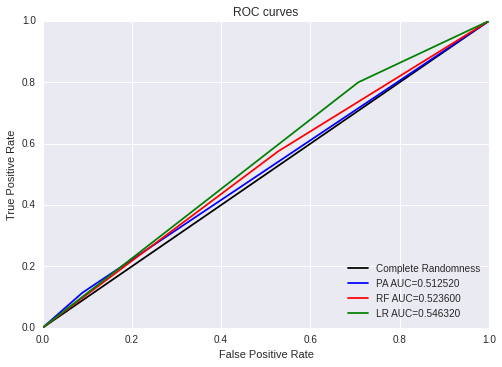

In [21]:
fast_roc_curves(train["sentiment"], tpa_class,trf_class,tlr_class)

#### See how bag of words performs with same number of features as bigrams and trigrams

In [22]:
small_vectorizer = CountVectorizer(analyzer = "word",   \
                             tokenizer = None,    \
                             preprocessor = None, \
                             stop_words = None,   \
                             max_features = 500) 
train_small_features = small_vectorizer.fit_transform(kag_list)
train_small_features = train_small_features.toarray()

spa_class,srf_class,slr_class = print_fastscores(train_small_features,train["sentiment"])

Passive Aggressive Classifier: 0.78
Random Forest Classifier:      0.75
Logistic Regression:           0.84
Dump Classifier: 0.50


#### Test slower classifiers with fewer features

In [23]:
print_slowscores(train_small_features,train["sentiment"])

K Nearest Neighbor Classifier: 0.65
Gradient Boosting Classifier:  0.81
Support vector machine(SVM):   0.84


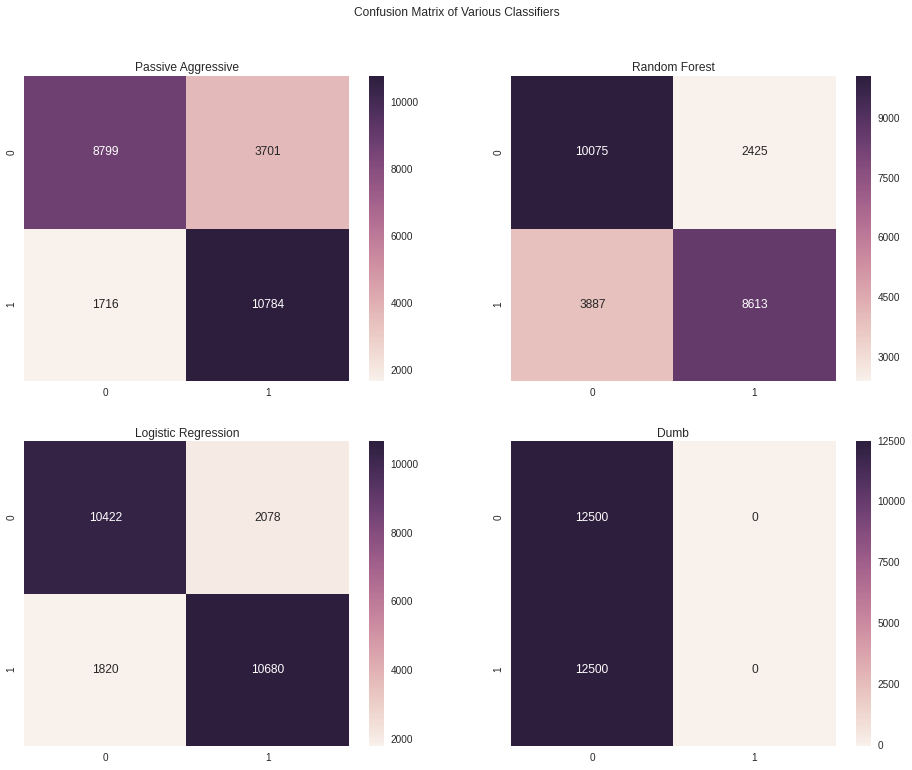

In [24]:
spa_conf_matrix,srf_conf_matrix,slr_conf_matrix,sdumb_conf_matrix = fast_confusion_matrices(train["sentiment"], 
                                                                         spa_class,srf_class,slr_class)
draw_conf_matrix(spa_conf_matrix,srf_conf_matrix,slr_conf_matrix,sdumb_conf_matrix)